## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.metrics import (confusion_matrix,ConfusionMatrixDisplay,accuracy_score, 
       plot_roc_curve, roc_auc_score, recall_score,
    precision_score, f1_score, classification_report, RocCurveDisplay)


In [2]:
df=pd.read_csv('./chronic_kidney_disease_full.csv')

In [3]:
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer:

age,bp,sg,al,su,rbc

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [139]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [140]:
df.dropna()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,ckd
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,ckd
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


Answer:Only 158 rows left,out of 400 rows.
disadvantage:No enough data,we won't get accurate predictions.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:Imprecise in predicting accuracy,inaccurate to get good model.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.


Create a null model with all yes,No false predictions.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:Accuracy.yes we minimize false negative.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:Sensitivity will be less.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer:yes,build a null model with no false predictions.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:Accuracy.yes we minimize false negative.


### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer:Sensitivity is less.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [141]:
df.head(2)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd


In [4]:
new_df=df[['age','bp','sg','appet','pc','pe','class']]
new_df.head(2)

,age,bp,sg,appet,pc,pe,class
0,48.0,80.0,1.02,good,normal,no,ckd
1,7.0,50.0,1.02,good,normal,no,ckd


In [5]:
X=new_df.drop(columns='class')
X.head()

,age,bp,sg,appet,pc,pe
0,48.0,80.0,1.020,good,normal,no
1,7.0,50.0,1.020,good,normal,no
2,62.0,80.0,1.010,poor,normal,no
3,48.0,70.0,1.005,poor,abnormal,yes
4,51.0,80.0,1.010,good,normal,no


In [6]:
X.isnull().sum()

age       9
bp       12
sg       47
appet     1
pc       65
pe        1
dtype: int64

In [7]:
X.fillna(0,inplace=True)

In [8]:
y=new_df['class']

In [9]:
X.shape

(400, 6)

In [10]:
y.shape

(400,)

In [11]:
#creating dummy column

In [12]:
X1=pd.get_dummies(data=X,columns=['appet','pc','pe'])

In [13]:
X1.head(2)

,age,bp,sg,appet_0,appet_good,appet_poor,pc_0,pc_abnormal,pc_normal,pe_0,pe_no,pe_yes
0,48.0,80.0,1.02,0,1,0,0,0,1,0,1,0
1,7.0,50.0,1.02,0,1,0,0,0,1,0,1,0


In [14]:
#getting polynomial feature

In [15]:
poly=PolynomialFeatures(include_bias=False)

In [16]:
poly

PolynomialFeatures(include_bias=False)

In [17]:
X2=poly.fit_transform(X1)

In [18]:
fe=poly.get_feature_names_out(X1.columns)

In [19]:
D=pd.DataFrame(data=X2,columns=fe)

In [20]:
D.head()

,age,bp,sg,appet_0,appet_good,appet_poor,pc_0,pc_abnormal,pc_normal,pe_0,...,pc_normal^2,pc_normal pe_0,pc_normal pe_no,pc_normal pe_yes,pe_0^2,pe_0 pe_no,pe_0 pe_yes,pe_no^2,pe_no pe_yes,pe_yes^2
0,48.0,80.0,1.020,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7.0,50.0,1.020,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,62.0,80.0,1.010,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,48.0,70.0,1.005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,51.0,80.0,1.010,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=42,stratify=y)

In [22]:
log=LogisticRegression()
log

LogisticRegression()

In [23]:
log.fit(X_train, y_train)

/Users/lubna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [162]:
# Evaluate model
log.score(X_train, y_train), log.score(X_test, y_test)#accuracy

#The proportion of correct predictions made.

#Count of (correct predictions)/(all predictions)

(0.8395522388059702, 0.8712121212121212)

In [47]:
y_pre=log.predict(X_test)

In [48]:
y_pre

array(['notckd', 'notckd', 'notckd', 'notckd', 'notckd', 'notckd',
       'notckd', 'ckd', 'ckd', 'notckd', 'notckd', 'notckd', 'ckd',
       'notckd', 'ckd', 'ckd', 'notckd', 'ckd', 'notckd', 'ckd', 'ckd',
       'ckd', 'notckd', 'notckd', 'ckd', 'notckd', 'notckd', 'ckd', 'ckd',
       'notckd', 'notckd', 'notckd', 'ckd', 'notckd', 'notckd', 'notckd',
       'ckd', 'ckd', 'ckd', 'ckd', 'ckd', 'notckd', 'notckd', 'ckd',
       'notckd', 'notckd', 'ckd', 'notckd', 'notckd', 'ckd', 'ckd', 'ckd',
       'ckd', 'ckd', 'notckd', 'ckd', 'ckd', 'ckd', 'notckd', 'notckd',
       'notckd', 'notckd', 'ckd', 'ckd', 'ckd', 'notckd', 'notckd',
       'notckd', 'notckd', 'ckd', 'notckd', 'ckd', 'ckd', 'notckd', 'ckd',
       'ckd', 'notckd', 'ckd', 'ckd', 'notckd', 'ckd', 'ckd', 'ckd',
       'ckd', 'ckd', 'ckd', 'ckd', 'ckd', 'ckd', 'ckd', 'ckd', 'ckd',
       'notckd', 'ckd', 'ckd', 'ckd', 'ckd', 'notckd', 'ckd', 'ckd',
       'ckd', 'notckd', 'ckd', 'notckd', 'ckd', 'ckd', 'ckd', 'notckd',
     

In [182]:
#  Generate predicted probabilities.
np.round(log.predict_proba(X_test), 3)[:10]

array([[0.168, 0.832],
       [0.442, 0.558],
       [0.093, 0.907],
       [0.181, 0.819],
       [0.341, 0.659],
       [0.316, 0.684],
       [0.417, 0.583],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.243, 0.757]])

In [165]:
log.intercept_

array([-0.00262554])

In [166]:
log.coef_

array([[ 1.24683993e-02,  6.92066629e-03, -2.73382681e-03,
         8.09608928e-04, -2.05395496e-03, -1.38093851e-03,
        -5.21020149e-04, -1.95959396e-03, -1.44670429e-04,
         8.09608928e-04, -8.27807494e-04, -2.60708597e-03,
        -1.32152919e-03,  4.01700926e-04,  2.77604743e-02,
         6.07206696e-02, -5.13174812e-03, -4.31205222e-02,
         2.30459222e-02, -4.53039158e-02,  3.47263929e-02,
         6.07206696e-02,  3.06678405e-03, -5.13190544e-02,
        -1.28636405e-03, -5.33701839e-03,  4.85765357e-02,
         1.66075972e-02, -5.82634666e-02,  4.26813566e-02,
        -7.91685880e-02,  4.34078977e-02,  4.85765357e-02,
         2.42903325e-02, -6.59462018e-02, -2.36477379e-03,
         8.25801106e-04, -2.20385828e-03, -1.35576964e-03,
        -7.89784438e-04, -1.98357164e-03,  3.95292704e-05,
         8.25801106e-04, -1.10985671e-03, -2.44977120e-03,
         8.09608928e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  8.09608928e-0

In [167]:
pd.DataFrame(data=log.coef_,columns=D.columns).T

,0
age,0.012468
bp,0.006921
sg,-0.002734
appet_0,0.000810
appet_good,-0.002054
...,...
pe_0 pe_no,0.000000
pe_0 pe_yes,0.000000
pe_no^2,-0.000828
pe_no pe_yes,0.000000


In [168]:

#1 unit change in xi means that success is  𝑒𝛽𝑖 times as likely.

As age increases by 1, the log-odds of someone being getting ckd increases by .1%.

As bp increases by 1, someone is about .6% times as likely to get ckd.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [169]:
appet_good = -0.002054

# if appet is good,the chance of getting the ckd decreases by 2%.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

The coefficients in a logistic regression model are interpretable. (They represent the change in log-odds caused by the input variables.)
Logistic regression is a very fast model to fit and generate predictions from.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [170]:
cm=confusion_matrix(y_test,y_pre)
cm

array([[70, 13],
       [ 4, 45]])

In [171]:
cm.ravel() #tn, fp, fn, tp

array([70, 13,  4, 45])

In [172]:
tn,fp,fn,tp=cm.ravel()
print(tn,fp,fn,tp)

70 13 4 45


In [41]:
tn=70
fp=13
fn=4
tp=45

It make sense to generate a confusion matrix on our test data because 
we need to undestand howmuch we predicted correctly.

In [203]:
#ConfusionMatrixDisplay.from_predictions(y_test, y_pre)

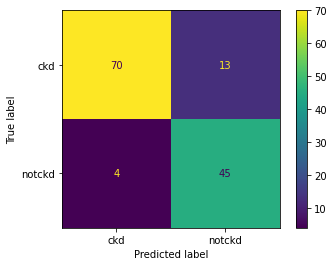

In [204]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(log, X_test, y_test);

In [42]:
# test specificity of our model
spec = tn / (tn + fp)
spec

#The proportion of actual negatives correctly diagnosed by the model

#(count of true negatives) + (count of all actual negatives, including the misclassified ones)

0.8433734939759037

In [43]:
sens = tp / (tp + fn)
sens

# sensitivity:The proportion of actual positives correctly diagnosed by the model
#recall = recall_score(y_test, y_pre, pos_label='notckd')


0.9183673469387755

In [55]:
# precision : What proportion of predicted positives are correct?

# tp / (tp + fp)
precision = precision_score(y_test,y_pre, pos_label='notckd')
precision

0.7758620689655172

In [57]:
#F1 score

#. 2 * (precision*recall) / (precision+recall)

f1_score(y_test,y_pre, pos_label='notckd')

0.8411214953271028

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer:we want to check sensitivity,because we don't want any false predictions.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

In [177]:
df['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

Answer:The model will be biased towards the majority class only. This causes a problem when we are interested in the prediction of the minority class.Here, Ckd dataset problem having ckd is important over not having ckd).

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:The model  will  unbalanced data will be biased towards the majority class only. This causes a problem when we are interested in the prediction of the minority class.if we are tring to predict cancer,we should have a dataset with more cancer patients than not having cancer.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [32]:
import random


In [73]:
df_ckd=df[df['class']=='ckd']


In [75]:
df_ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [76]:
df_ckd.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            240, 241, 242, 243, 244, 245, 246, 247, 248, 249],
           dtype='int64', length=250)

In [87]:
new_sample=df_ckd.sample(replace=True,n=200000)
new_sample

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
96,60.0,80.0,1.010,1.0,1.0,NaN,normal,notpresent,notpresent,172.0,...,36.0,NaN,NaN,no,yes,yes,poor,no,no,ckd
97,65.0,60.0,1.015,1.0,0.0,NaN,normal,notpresent,notpresent,91.0,...,32.0,9100.0,4.0,yes,yes,no,poor,yes,no,ckd
94,65.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,93.0,...,36.0,11900.0,3.9,no,yes,no,good,no,no,ckd
23,21.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,NaN,NaN,NaN,no,no,no,poor,no,yes,ckd
245,48.0,100.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,103.0,...,19.0,7200.0,2.6,yes,no,yes,poor,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,70.0,70.0,1.015,2.0,NaN,NaN,NaN,notpresent,notpresent,NaN,...,NaN,NaN,NaN,no,yes,no,poor,yes,no,ckd
115,47.0,80.0,1.010,0.0,0.0,NaN,abnormal,notpresent,notpresent,NaN,...,44.0,5600.0,4.3,no,no,no,good,no,yes,ckd
58,73.0,80.0,1.020,2.0,0.0,abnormal,abnormal,notpresent,notpresent,253.0,...,33.0,7200.0,4.3,yes,yes,yes,good,no,no,ckd
216,64.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,107.0,...,38.0,NaN,NaN,no,no,no,good,no,no,ckd


In [90]:
final_df=pd.concat([df,new_sample],axis=0)

In [91]:
final_df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [110]:
XX=final_df[['age','bp','sg','al']]

In [111]:
yy=final_df['class']

In [112]:
XX.fillna(0,inplace=True)

/var/folders/jb/j64cnvc1129dnzfhx6cqpc580000gn/T/ipykernel_10506/2389848136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XX.fillna(0,inplace=True)


In [113]:
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.33,stratify=yy)

In [114]:
log_reg=LogisticRegression()

In [115]:
log_reg

LogisticRegression()

In [116]:
log.fit(X_train, y_train)

LogisticRegression()

In [117]:
log.score(X_train, y_train)

0.9992552209014807

In [118]:
log.score(X_test, y_test)

0.9992439363696849

More accuracy in prediction